# YOLOv5 ball detection
### References

* YOLOv5 repository - https://github.com/ultralytics/yolov5
* https://www.kaggle.com/code/eneszvo/yolov5-helmet-detection-train-and-inference

In [5]:
!nvidia-smi

Mon Sep  5 07:40:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    34W / 350W |    725MiB / 24576MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.2+cu113 (NVIDIA GeForce RTX 3090)


In [7]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import subprocess

import glob

In [8]:
class CFG:
    EXP_NAME = "BALL_DET_SAMPLE_SAVECONF"
    IMG_SIZE = 1280
    IMG_HEIGHT = 768
    IMG_WIDTH = 1280
    CONF_THR = 0.25

    YOLO_PATH = "./yolov5"
    MODEL_PATH = "yolov5l6_trained_600images.pt"# in yolov5 folder
    input_movie = "08fd33_0.mp4"# in yolov5 folder
    movie_id = "08fd33_0"
    DET_PATH = f"./{EXP_NAME}/exp/labels"

    orig_movie = f"../input/clips/{input_movie}"
    

In [9]:
!ls

Dockerfile  cuda-keyring_1.0-1_all.deb	requirements.txt  work
README.md   docker-compose.yaml		run.sh


In [10]:
%cd ./work/yolov5

/workdir/work/yolov5


In [11]:
!ls

08fd33_0.mp4		  data		       train.py
BALL_DET_SAMPLE_SAVECONF  detect.py	       tutorial.ipynb
CONTRIBUTING.md		  export.py	       utils
DFL			  hubconf.py	       val.py
LICENSE			  models	       yolov5l6_trained_600images.pt
README.md		  output_ball_det.mp4  {CFG.EXP_NAME}
__pycache__		  requirements.txt
classify		  setup.cfg


# YOLOv5 Inference with clip/08fd33_0.mp4

In [13]:
!python detect.py --img {CFG.IMG_SIZE} \
                  --weights {CFG.MODEL_PATH} \
                  --source {CFG.input_movie} \
                  --project {CFG.EXP_NAME} \
                  --save-txt \
                  --save-conf

detect: weights=['yolov5l6_trained_600images.pt'], source=08fd33_0.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=BALL_DET_SAMPLE_SAVECONF, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: unsafe repository ('/workdir/work/yolov5' is owned by someone else)
To add an exception for this directory, call:

	git config --global --add safe.directory /workdir/work/yolov5
YOLOv5 🚀 2022-9-4 Python-3.7.12 torch-1.10.2+cu113 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)

Fusing layers... 
Model summary: 476 layers, 76118664 parameters, 0 gradients
video 1/1 (1/750) /workdir/work/yolov5/08fd33_0.mp4: 768x1280 1 ball, 22.1ms
video 1/1 (2/750) /workdir/work/yolov5/08fd33_0.mp4: 768x1280 1 ball, 21.9ms
video 1/1 (3/750) /wor

# ボールの移動距離が長いところだけ切り取ってクロップしたい

In [14]:
def yolobbox_to_pixel(bbox_, WIDTH=CFG.IMG_WIDTH, HEIHGT=CFG.IMG_HEIGHT):
    x_min = int( (bbox[0] - bbox[2])*WIDTH )
    y_min = int( (bbox[1] - bbox[3])*HEIHGT )
    x_max = int( (bbox[0] + bbox[2])*WIDTH )
    y_max = int( (bbox[1] + bbox[3])*HEIHGT )
    return [x_min, y_min, x_max, y_max]

In [25]:
def yolobbox_to_croparea(bbox_, WIDTH=CFG.IMG_WIDTH, HEIHGT=CFG.IMG_HEIGHT):
    """
    検出したボールを中心として、CROP_AREA_X*2, CROP_AREA_Y*2の範囲をクロップする予定
    そのための座標情報を入力する。
    """

    x_mid = int( bbox_[0]*WIDTH )
    y_mid = int( bbox_[1]*HEIHGT )
    print(x_mid, y_mid)
    
    CROP_AREA_X = WIDTH // 8
    CROP_AREA_Y = HEIHGT // 8  
    print("CROP_X", CROP_AREA_X)
    print("CROP_Y", CROP_AREA_Y)
    x_min = x_mid - CROP_AREA_X
    x_max = x_mid + CROP_AREA_X
    if x_min < 0:
        x_min += abs(x_min)
        x_max += abs(x_min)
    elif x_max > WIDTH:
        x_min -= (x_max - WIDTH)
        x_max -= (x_max - WIDTH)

    y_min = y_mid - CROP_AREA_Y
    y_max = y_mid + CROP_AREA_Y
    if y_min < 0:
        y_min += abs(y_min)
        y_max += abs(y_min)
    elif y_max > HEIHGT:
        y_min -= (y_max - HEIHGT)
        y_max -= (y_max - HEIHGT)

    return [x_min, y_min, x_max, y_max]

In [26]:
bbox_files = glob.glob(f"{CFG.DET_PATH}/*.txt")

frame:1.0 : 	not detected.
frame:2.0 : 	(768, 1280, 3)


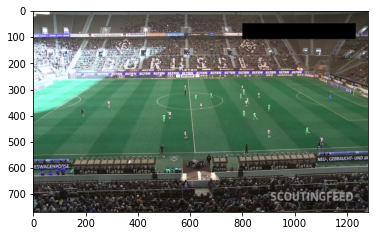

191 397
CROP_X 160
CROP_Y 96
ball_bbox [0.149219   0.517593   0.00572917 0.00925926]
area [31, 301, 351, 493]


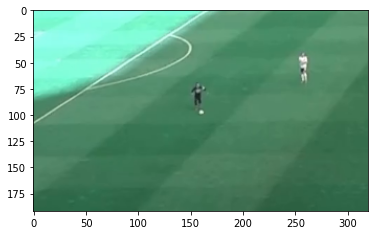

[0.149219   0.517593   0.00572917 0.00925926]
-
frame:3.0 : 	(768, 1280, 3)


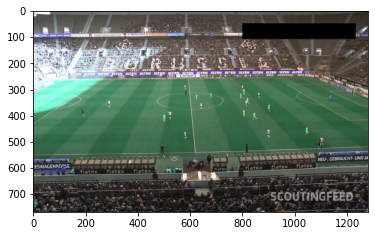

191 397
CROP_X 160
CROP_Y 96
ball_bbox [0.149479   0.518056   0.00520833 0.00833333]
area [31, 301, 351, 493]


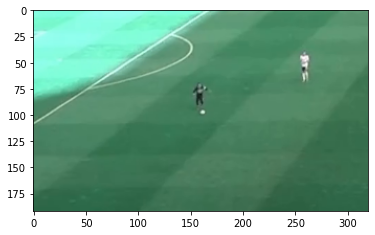

[0.149479   0.518056   0.00520833 0.00833333]
-
frame:4.0 : 	(768, 1280, 3)


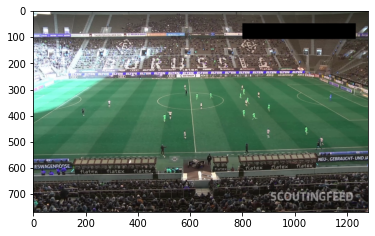

193 398
CROP_X 160
CROP_Y 96
ball_bbox [0.151042   0.518519   0.00520833 0.00925926]
area [33, 302, 353, 494]


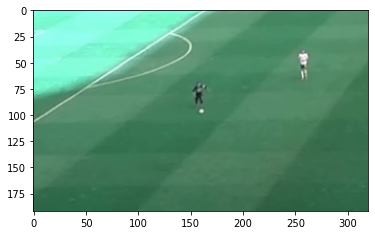

[0.151042   0.518519   0.00520833 0.00925926]
-


In [28]:
cap = cv2.VideoCapture(CFG.orig_movie)
frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for frame_id in range(frame_num):
    # Read frame image (cap.readはメソッドが実行されるたびに1フレーム分進める)
    ret, image = cap.read()
    print(f"frame:{cap.get(cv2.CAP_PROP_POS_FRAMES)} : ", end="\t")

    det_file_name = f"{CFG.DET_PATH}/{CFG.movie_id}_{frame_id}.txt"
    if not det_file_name in bbox_files:
        print("not detected.")
        continue

    else:
        # select highest conf bbox in txt-file
        with open(det_file_name, "rb") as f:
            det_file_data = f
            bbox_txt = [s.strip() for s in det_file_data.readlines()]
        if len(bbox_txt) > 1:
            best_conf = .0
            for bbox in bbox_txt:
                conf_and_bbox_list = str(bbox).strip("'").split(" ")
                ball_bbox = []
                conf_and_bbox = np.float_(conf_and_bbox_list[1:])
                print(conf_and_bbox)
                if best_conf < conf_and_bbox[4]:
                    best_conf = conf_and_bbox[4]
                    ball_bbox = conf_and_bbox[0:4]
        else:
            conf_and_bbox_list = str(bbox_txt).strip("'").split(" ")
            ball_bbox = np.float_(conf_and_bbox_list[1:5])
        
        
        image = cv2.resize(image, dsize=(CFG.IMG_WIDTH, CFG.IMG_HEIGHT))
        print(image.shape)
        plt.imshow(image)
        plt.show()

        crop_area = yolobbox_to_croparea(ball_bbox)
        print("ball_bbox",ball_bbox)
        print("area",crop_area)
        croped_image = image[crop_area[1]:crop_area[3], crop_area[0]:crop_area[2],  :]
        plt.imshow(croped_image)
        plt.show()

        
            
        print(ball_bbox)
        print("-")

        if cap.get(cv2.CAP_PROP_POS_FRAMES) > 3:
            break

In [ ]:
ball_bbox

array([0.110417  , 0.491667  , 0.00520833, 0.00740741])

In [ ]:
np.float_(ball_bbox)

array([0.110417  , 0.491667  , 0.00520833, 0.00740741])